In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from fastai.vision import *
from fastai.metrics import error_rate
import torch

torch.cuda.empty_cache()

In [2]:
# ganti loss ke focal loss
import pretrainedmodels
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()
    
# model nyta buat cnn_learner
def resnext50_32x4d(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext50_32x4d(pretrained=pretrained)
    return nn.Sequential(*list(model.children()))

In [3]:
#masukkin image dataset nya disini, tapi per folder harus ada labelnya
#Reference Implementation fastai --->>> https://gilberttanner.com/blog/fastai-image-classification
SZ=128
tfms = get_transforms(get_transforms(max_lighting=0.4, max_zoom=1.2, max_warp=0.2, max_rotate=20,
                                    xtra_tfms=[rand_crop(), rand_zoom(1, 1.5),
                                 symmetric_warp(magnitude=(-0.2, 0.2))]))
defaults.device = torch.device("cuda")
data = ImageDataBunch.from_folder(Path('dataset/'),
                                  train = 'train/',
                                  valid_pct = 0.2,
                                  ds_tfms = tfms,
                                  size = SZ,
                                  bs = 64,
                                  num_workers = 50
                                  ).normalize(imagenet_stats)

In [4]:
assert(len(data.classes) == 42)

In [5]:
# model fastai --->>> https://docs.fast.ai/vision.models.html
# best practice: start small, 
# baru ganti model IF tuning hyperparameter udah gak improved.
learn = cnn_learner(data, 
                    resnext50_32x4d, 
                    pretrained=True, 
                    cut=-2, 
                    metrics = [accuracy]
                   )
learn.loss_fn = FocalLoss()
learn = learn.mixup().to_fp16()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 5.75E-03


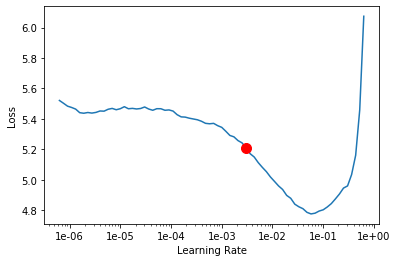

In [6]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr


In [ ]:
learn.fit_one_cycle(25, max_lr=slice(min_grad_lr/10, min_grad_lr))

In [ ]:
learn.save('resnext50_32x4d_1_mixup_fp16');
learn.unfreeze();
learn = learn.clip_grad();

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr


In [ ]:
learn.load('resnext50_32x4d_1_mixup_fp16');
learn.unfreeze();
learn = learn.clip_grad();

In [ ]:
learn.fit_one_cycle(12, slice(min_grad_lr/10, min_grad_lr))

In [ ]:
learn.save('resnext50_32x4d_2');

# resnext 
## size 224

In [ ]:
SZ = 224
cutout_frac = 0.20
p_cutout = 0.75
cutout_sz = round(SZ*cutout_frac)
cutout_tfm = cutout(n_holes=(1,1), length=(cutout_sz, cutout_sz), p=p_cutout)
tfms = get_transforms(get_transforms(max_lighting=0.4, max_zoom=1.2, max_warp=0.2, max_rotate=20, xtra_tfms=[flip_lr()]))
defaults.device = torch.device("cuda")
data = ImageDataBunch.from_folder(Path('dataset/'),
                                  train = 'train/',
                                  valid_pct = 0.2,
                                  ds_tfms = tfms,
                                  size = SZ,
                                  bs = 32,
                                  num_workers = 50
                                  ).normalize(imagenet_stats)


In [ ]:
len(data.classes)

In [ ]:
# model fastai --->>> https://docs.fast.ai/vision.models.html
# best practice: start small, 
# baru ganti model IF tuning hyperparameter udah gak improved.
# learn = cnn_learner(data, 
#                     resnext50_32x4d, 
#                     pretrained=True, 
#                     cut=-2, 
#                     metrics = [accuracy]
#                    ).mixup()
learn.data = data

In [ ]:
learn.load('resnext50_32x4d_2');
learn.freeze();
learn = learn.clip_grad();
learn.loss_fn = FocalLoss()


In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [ ]:
learn.fit_one_cycle(5, slice(min_grad_lr/10, min_grad_lr))

In [ ]:
# learn.save('resnext50_32x4d_1_224');
learn.load('resnext50_32x4d_1_224');


In [ ]:
learn.unfreeze();
learn = learn.clip_grad()
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr



In [ ]:
learn.fit_one_cycle(15, slice(min_grad_lr/10, min_grad_lr))


In [ ]:
learn.save('resnext50_32x4d_2_224');
import os 
os.system('python finish_me.py')

# resnext 50
## size 299

In [ ]:
SZ = 299
cutout_frac = 0.20
p_cutout = 0.75
cutout_sz = round(SZ*cutout_frac)
cutout_tfm = cutout(n_holes=(1,1), length=(cutout_sz, cutout_sz), p=p_cutout)
tfms = get_transforms(get_transforms(max_lighting=0.4, max_zoom=1.2, max_warp=0.2, max_rotate=20, xtra_tfms=[flip_lr()]))
defaults.device = torch.device("cuda")
data = ImageDataBunch.from_folder(Path('dataset/'),
                                  train = 'train/',
                                  valid_pct = 0.2,
                                  ds_tfms = tfms,
                                  size = SZ,
                                  bs = 64,
                                  num_workers = 50
                                  ).normalize(imagenet_stats)

In [ ]:
learn.data=data
learn.load('resnext50_32x4d_1_299')

learn.freeze();
learn = learn.clip_grad();

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [ ]:
learn.fit_one_cycle(9, slice(min_grad_lr/10, min_grad_lr))

In [ ]:
learn.save('resnext50_32x4d_1_299');
os.system('python finish_me.py')


In [ ]:
learn.load('resnext50_32x4d_1_299');

In [ ]:
learn.unfreeze();
learn = learn.clip_grad();

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [ ]:
learn.fit_one_cycle(10, slice(min_grad_lr/10, min_grad_lr))

In [ ]:
learn.export('./models/final_fastai')

# using ResNeXt-101-32x8d

In [ ]:
import pretrainedmodels
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()
    
# model nyta buat cnn_learner
def resnext101_32x8d(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext101_32x4d(pretrained=pretrained)
    return nn.Sequential(*list(model.children()))

In [ ]:
#masukkin image dataset nya disini, tapi per folder harus ada labelnya
#Reference Implementation fastai --->>> https://gilberttanner.com/blog/fastai-image-classification
SZ=229
tfms = get_transforms(get_transforms(max_lighting=0.4, max_zoom=1.2, max_warp=0.2, max_rotate=20, xtra_tfms=[flip_lr()]))
defaults.device = torch.device("cuda")
data = ImageDataBunch.from_folder(Path('dataset/'),
                                  train = 'train/',
                                  valid_pct = 0.2,
                                  ds_tfms = tfms,
                                  size = SZ,
                                  bs = 32,
                                  num_workers = 50
                                  ).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, 
                    resnext101_32x8d, 
                    pretrained=True, 
                    cut=-2, 
                    metrics = [accuracy]
                   )
learn.loss_fn = FocalLoss()


In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr


In [ ]:
learn.fit_one_cycle(10, slice(min_grad_lr/10, min_grad_lr))

In [ ]:
learn.save('resnext101_32x8d');
learn.unfreeze();
learn = learn.clip_grad();

In [ ]:
learn.load('resnext101_32x8d');
learn.unfreeze();
learn = learn.clip_grad()
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr



In [ ]:
learn.fit_one_cycle(10, slice(min_grad_lr/10, min_grad_lr))

In [ ]:
learn.save('resnext101_32x8d_2');
learn.export('resnext101_32x8d_2');
